# Aplicación del Algoritmo de búsqueda A* en la Navegación Robótica

Méndez Pool Joan de Jesús | 160300102 <br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cv2
import itertools
from IPython.display import HTML
%matplotlib inline
#%matplotlib notebook

# Elementos del problema


* Suponemos que tenemos un **robot** que podemos representar como un **polígono convexo** definido sobre un punto que se utilizará como marco de referencia: $\mathcal{R}(x,y)$.
* Los movimientos del robot se limitan a **desplazamientos** (traslaciones) y rotaciones en un plano bidimensional.
* En el plano, se encuentran distribuidos una serie de **obstáculos** físicos los cuales no pueden ser atravesados por el robot: $\mathcal{P} = \{P_1, P_2, P_3, \ldots, P_n\}$.
* El **objetivo** es desplazar al robot, sobre el plano, hasta un punto fijo **sin colisionar** con los obstáculos.

# Problema principal
<p style="text-align:justify">Definimos la imagen del problema principal por medio de una función.</p>

In [2]:
# Definición de Colores
black, red, green, blue, white = ((0,0,0),(255,0,0),(0,255,0),(0,0,255),(255,255,255)) 
Goal, Path = ((15,150,0), (81,209,246))

class TestCases:
    def mainproblem():
        image = np.zeros((512,512,3), np.uint8)

        #dibuja una serie de obstáculos
        cv2.rectangle(image, (100,100), (150,150), (255,255,255), -1)
        cv2.rectangle(image, (350,200), (380,240), (255,255,255), -1)
        cv2.rectangle(image, (100,400), (150,480), (255,255,255), -1)

        #ubicación del robot
        [x,y] = [250, 250]
        pts = np.array( [[x,y], [x-25,y+25], [x+25,y+25]], np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.fillPoly(image, [pts], (0,0,255))

        #objetivo
        cv2.circle(image, (400, 25), 10, (15,150,0), -1)
        return image

    # Métodos para realizar Pruebas
    def Prueba1():
        image = np.zeros((170,180,3), np.uint8)

        #ubicación del robot
        [x,y] = [15, 15]
        pts = np.array( [[x,y], [x-10,y+10], [x+10,y+10]], np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.fillPoly(image, [pts], blue)
        #cv2.circle(image, (20,25), 24, green, -1) # Nodo Inicial

        #objetivo
        cv2.circle(image, (100, 114), 10, Goal, -1)
        #cv2.rectangle(image, (100,124), (100,124), red, -1) # Nodo Final 

        # Obstaculos
        cv2.rectangle(image, (40,5), (80,136), white, -1) # Nodos Sólidos

        return image

    def Prueba2():
        image = np.zeros((300,300,3), np.uint8)
        # Nodo Inicial
        [x,y] = [100, 50]
        pts = np.array( [[x,y], [x-15,y+15], [x+15,y+15]], np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.fillPoly(image, [pts], blue)

        #objetivo
        cv2.circle(image, (250, 214), 10, Goal, -1)
        # Nodos Sólidos
        cv2.rectangle(image, (40,10), (80,50), white, -1) 
        cv2.rectangle(image, (210,60), (240,130), white, -1) 

        cv2.rectangle(image, (60,240), (140,270), white, -1) 
        cv2.rectangle(image, (120,140), (200,180), white, -1) 

        #cv2.rectangle(image, (3,3), (3,3), white, -1)
        return image

# Algoritmo A* Search

In [3]:
# Estructura de datos que representa cada nodo del mapa
class Node:
    def __init__(self, node, father, gscore, fscore):
        self.node = node
        self.father = father
        self.gscore = gscore
        self.fscore = fscore
        
class AStarSearch:
    
    def __init__(self, image):
        self.image = image
        self.start, self.radius = self.Robot_Gravity_Center()
        self.goal, self.radiusg = self.Goal_Gravity_Center()
        self.DT_Solids = self.Distance_Transform()
        self.DT_Goal = self.Distance_Transform(solids=False)
        
    # Despliega una imagen
    def Plot(self, image, title=' '):
        plt.title(title)
        plt.imshow(image, cmap="gray")
        plt.axis("off")
        plt.show()
    # Dibuja el camino encontrado
    def Draw_Path(self, path):
        imc = self.image.copy()
        for (x,y) in path:
            cv2.rectangle(imc, (x,y), (x,y), Path, -1) 
        self.Plot(imc)
        
    # Detección de elementos ( Robot y Meta )

    # Por medio de estas funciones nos encargamos de detectar tonalidades de píxeles sobre el mapa a trabajar, 
    # con ello podemos detectar la ubicación del robot y la meta, para el robot podemos calcular los puntos 
    # que conforman al polígono y de esta forma calcular el centro de gravedad y el radio que envuelve la 
    # circunferencia, para la meta podemos calcular el centro de gravedad.

    # Crea una lista con los pixeles de cierto color dado
    def Pixel_list(self, colour):
        ls = []
        for (y, column) in enumerate(self.image):
            for (x, value) in enumerate(column):
                if (tuple(value) == colour):
                    ls.append((x,y))
        return ls

    # Calcula el Centro de Gravedad del Robot y el radio de la circuferencia
    def Robot_Gravity_Center(self):
        # Creamos un arreglo estructurado con la lista de coordenadas de la tonalidad que representa al robot
        dt = np.dtype([('x',int), ('y', int)])
        recarray = np.array(self.Pixel_list(blue), dtype=dt )
        # Ordenamos respecto a ambos ejes
        sortx = list(np.sort(recarray, order='x'))
        sorty = list(np.sort(recarray, order='y'))
        # Obtenemos el punto en y más bajo, el punto en x más bajo y el punto en x más alto
        pts = np.array([list(sorty[0]), list(sortx[0]), list(sortx[-1])], dtype=np.int32)
        # Obtenemos el Centro de gravedad del polígono
        (cx, cy) = (int(pts[:,0].mean()), int(pts[:,1].mean()))
        radius = []
        for (x,y) in pts:
            # Calculamos el radio respecto a cada punto del polígono
            radius.append(int(np.sqrt((x-cx)**2 + (y-cy)**2)))
        # No quedamos con el mayor valor de radio
        r = max(radius)
        return ((cx,cy), r)

    # Calcula el Centro de Gravedad de la meta y el radio de la circuferencia
    def Goal_Gravity_Center(self):
        # Creamos un arreglo estructurado con la lista de coordenadas de la tonalidad que representa la meta
        dt = np.dtype([('x',int), ('y', int)])
        # Obtenemos un arreglo estructura ordenado respecto al eje y
        pixel = np.sort(np.array(self.Pixel_list(Goal), dtype=dt), order='y')
        # Obtenemos el punto más alto y el más abajo sobre la circuferencia de la meta
        pt1 = pixel[0]
        pt2 = pixel[-1]
        # Calculamos el punto central de la meta
        pt = (int((pt1['x']+pt2['x'])/2), int((pt1['y']+pt2['y'])/2))
        # Calculamos el radio de la meta
        r = int(np.sqrt((pt1['x']-pt[0])**2 + (pt1['y']-pt[1])**2))
        return (pt, r)
    
    # Funciones de Distance Transform ( OpenCV )

    # A partir de estas funciones podemos obtener las imágenes que representan la Transformación Distancia
    # sobre el mapa a trabajar, por medio de las siguientes instrucciones podemos obtener la distancia que 
    # tiene cada píxel hacia los obstáculos y de igual forma la distancia que existe hacia el objetivo de 
    # la navegación.</p>

    # Invierte la imagen binaria reconociendo unicamente los obstáculos sobre el grid
    def Detect_Solids(self):
        # Crea una nueva imagen
        invbin = np.zeros((self.image.shape[:2]), np.uint8)
        # Recorremos la imagen pixel por pixel
        for (y,column) in enumerate(self.image):
            for (x,value) in enumerate(column):
                # Si la tonalidad encontrada es igual al valor de los sólidos se agrega 0 al valor de la
                # posición actual, si no un número muy grande
                invbin[y][x] = (0) if (tuple(value) == white) else (10**3)
        return invbin

    # Invierte la imagen binaria reconociendo el objetivo de la navegación
    def Detect_Goal(self):
        # Creamos una imagen nueva
        inv = np.zeros((self.image.shape[:2]), np.uint8)
        # Asignamos la tonalidad blanca a las coordenadas centrales de la meta
        inv[self.goal[1]][self.goal[0]] = 255
        # Invertimos la imagen binaria en sus tonalidades
        retval, inv = cv2.threshold(inv, 0, 255, cv2.THRESH_BINARY_INV)
        return inv

    # Aplica Transformación Distancia a las imágenes binarias invertidas con la librería OpenCV
    def Distance_Transform(self, solids=True):
        if solids:
            # Aplica transformación distancia a los sólidos
            distance_transform = cv2.distanceTransform(self.Detect_Solids(), cv2.DIST_LABEL_PIXEL, 3)
        else:
            # Aplica transformación distancia a la meta
            distance_transform = cv2.distanceTransform(self.Detect_Goal(), cv2.DIST_LABEL_PIXEL, 3)
        return distance_transform

    # A Start Search ######################

    # Las siguientes funciones son complementarias para la creación del Algoritmo de búsqueda A estrella, 
    # las funciones fueron separadas las funciones para simplificar un poco las líneas de código y se 
    # parezca al pseudocódigo utilizado para su implementación.

    # Calcula la distancia heurística de la posición actual al objetivo
    def heuristic_cost_estimate(self, position):
        # Distancia heurística obtenida con la aplicación de distance transform a la meta
        (x,y) = position
        # Regresa el valor de la tonalidad en la imagen que representa la distancia 
        # hacia el objetivo en la posición dada
        return self.DT_Goal[y][x]

    # Determina si las coordenadas actuales están dentro del rango y dominio de la imagen
    def Image_Range(self, coor):
        (cx, cy) = coor
        # Comparación de arreglos booleanos con funciones lógicas de numpy
        flag = np.logical_and([cx >= 0, cy >= 0], [cx < self.image.shape[1], cy < self.image.shape[0]])
        return np.logical_and(flag[0], flag[1])

    # Determina las coordenadas vecinas a movernos sobre el grid de un determinado punto en la imagen
    def Neighbors(self):
        # Valores que nos permiten navegar en el grid a los 8 vecinos más cercanos por medio 
        # del índice de las coordenadas alrededor del pixel actual
        # permuta = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
        permutations = [(-1,-1)]
        permutations.extend(list(itertools.permutations([-1, 0, 1], 2)))
        permutations.append((1,1))
        return permutations

    # Calcula la distancia hacia los sólidos en el grid
    def Distance_Solid(self, coor):
        (cx, cy) = coor
        # Operación sobre la transformación distancia a los sólidos que nos indica que tan lejana 
        # es la distancia de la posición dada a algún sólido cercano, con el radio del robot podemos 
        # anticipar la distancia para evitar movernos sobre coordenadas que pueden hacernos colisionar 
        # con los sólidos
        return (self.DT_Solids[cy][cx] >= self.radius + 10)
    
    # Reconstruye el camino de la lista cerrada
    def reconstruct_path(self, closedset, current):
        # Creamos una lista donde se guardará cada pixel del camino encontrado
        path = [current.node]
        if closedset:
            # Crea una lista de Nodos
            Nodes = list(map(lambda x: x.node, closedset))
            # Obtenemos el nodo padre de la meta
            api = closedset[Nodes.index(current.father)]
            # Mientras el nodo padre del nodo actual no apunte a si mismo
            while api.node != api.father:
                # Guarda el nodo en la lista de pixeles que representan el camino
                path.append(api.node)
                # Moverse al nodo padre del nodo actual
                api = closedset[Nodes.index(api.father)]
        # Apilar el nodo de inicio del camino
        path.append(api.node)
        # Regresa la lista invertida
        return path[::-1]
    
    # Algoritmo de búsqueda A*
    def A_Star_Search(self):
        # Creamos listas vacías para listar los nodos evaluados y por evaluar
        openset = []
        closedset = []
        # Apilamos el primer elemento a la lista abierta (lista de espera)
        openset.append( Node(self.start, self.start, 0, self.heuristic_cost_estimate(self.start)) )
        # Lista de los vecinos más cercanos para cierto nodo
        neighborhood = self.Neighbors()
        # Nodos vecinos diagonales
        diag = set(((-1,-1),(-1,1),(1,-1),(1,1)))
        # Mientras la lista abierta no este vacía
        while openset:
            # Obtener el nodo con menor fScore de la lista abierta
            openset = sorted(openset, key=lambda node: node.fscore)
            current = openset[0]
            # Si el nodo actual es igual al objetivo se reconstruye el camino hacia la meta
            if (current.node == self.goal):
                return self.reconstruct_path(closedset, current)
            # Se elimina el nodo actual de la lista abierta y se agrega a la lista cerrada
            closedset.append(openset.pop(0))
            # Posición actual
            (cx, cy) = current.node
            # Listar los nodos
            lnclosed = list(map(lambda x: x.node, closedset))
            lnopen = list(map(lambda x: x.node, openset))
            # Para cada vecino de la posición actual
            for (x,y) in neighborhood:
                # Verificar si la coordenada vecina no sale de los bordes de la imagen
                if self.Image_Range((cx+x,cy+y)):
                    # Anticipar los obstáculos sobre la transformación distancia con el radio del robot
                    if self.Distance_Solid((cx+x,cy+y)):
                        # Si el nodo vecino se encuentra en la lista cerrada de nodos pasa 
                        # a la siguiente interacción
                        if (cx+x, cy+y) in lnclosed:
                            continue
                        # Si el movimiento del nodo actual al nodo vecino es diagonal tiene un mayor coste
                        distance_between = 14 if ((x,y) in diag) else 10
                        # Se obtiene una tentativa de gScore entre la posición actual al nodo vecino
                        tentative_gScore = current.gscore + distance_between
                        if (cx+x, cy+y) not in lnopen: 
                            # Añade el nuevo nodo a la lista abierta
                            openset.append( Node((cx+x, cy+y), current.node, tentative_gScore, 
                                 tentative_gScore + self.heuristic_cost_estimate((cx+x, cy+y))))
                        else:
                            # Si la tentativa de gScore no es mayor o igual al gScore de la posición actual
                            if not (tentative_gScore >= current.gscore):
                                # Se actualiza el nodo padre y los valores de gScore y 
                                # fScore del vecino evaluado
                                ID = lnopen.index((cx+x, cy+y))
                                openset[ID] = Node( (cx+x, cy+y), current.node, tentative_gScore, 
                                     tentative_gScore + self.heuristic_cost_estimate((cx+x, cy+y)))

    # Función de Simulación de la trayectoria a seguir

    # La siguiente función se encarga de crear una animación que simula el recorrido encontrado por 
    # el Algoritmo de búsqueda A estrella, la animación es creada con la librería matplotlib de Python
    # y desplegada como una animación de Javascript.
    
    # Simula el recorrido del camino obtenido
    def Path_Simulator(self, path):
        # Crea una nueva imagen que servirá de plantilla para dibujar el movimiento
        imc = self.image.copy()
        # Borra la ubicación del robot
        pt = (path[0][0], path[0][1])
        cv2.circle(imc, pt, self.radius+5, black, -1)
        # Guarda la primera imagen en la lista
        gif = [self.image, self.image, self.image, self.image, self.image, self.image]
        # Recorre cada pixel encontrado con el algoritmo A*
        for (x,y) in path[:]:
            # Creamos una copia para dibujar la circuferencia del robot
            im = imc.copy()
            cv2.circle(im, (x,y), self.radius, blue, -1)
            gif.append(im)
        # Código para la creación de la animación en JS # Funciona
        fig = plt.figure()
        plt.axis('off')
        # ims is a list of lists, each row is a list of artists to draw in the current frame; 
        # here we are just animating one artist, the image, in each frame
        ims = []
        for i in range(len(gif)):
            im = plt.imshow(gif[i], animated=True)
            ims.append([im])
        ani = animation.ArtistAnimation(fig, ims, interval=10, blit=True, repeat_delay=200)
        return HTML(ani.to_jshtml())
        
    # Función de Navegación Robótica

    # Está función se encarga de integrar todas las anteriores para realizar todos los cálculos 
    # necesarios antes de aplicar el algoritmo de búsqueda, ejecuta dicha búsqueda 
    # y después se encarga de crear la animación respectiva al recorrido encontrado.
    def Robotic_Navigation(self):
        # Aplicamos A* Search a las coordenadas del centro de gravedad del robot hacia 
        # el centro de gravedad de la meta sobre la imagen 
        path = self.A_Star_Search()
        # Despliega la imagen a trabajar
        self.Plot(self.image)
        # Dibuja el camino encontrado con A* Search
        self.Draw_Path(path)
        # Regresa la animación que representa una simulación del recorrido
        return self.Path_Simulator(path)

## Imagen del problema principal

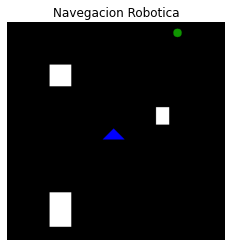

In [4]:
image = TestCases.mainproblem()
example = AStarSearch(image) 
example.Plot(image,'Navegacion Robotica')

## Detección de elementos ( Robot y Meta )

### Ejemplo
<p style="text-align:justify">Probaremos las funciones para envolver al robot en un círculo y redibujar con otro color la meta para verificar que las funciones trabajan correctamente.</p>

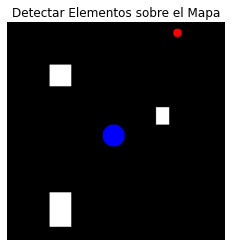

In [5]:
imc = image.copy()
start, radius = example.Robot_Gravity_Center()
goal, radiusg = example.Goal_Gravity_Center()
# Redibujar las figuras sobre la imagen
cv2.circle(imc, start, radius, blue, -1)
cv2.circle(imc, goal, radiusg, red, -1)
example.Plot(imc, 'Detectar Elementos sobre el Mapa')

## Transformación Distancia

### Ejemplo
<p style="text-align:justify">Probaremos las funciones para calcular la <i>Transformación Distancia</i> tanto hacia los obstáculos como a la meta.</p>

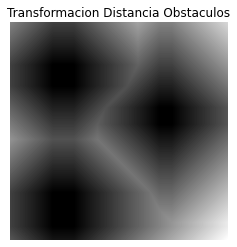

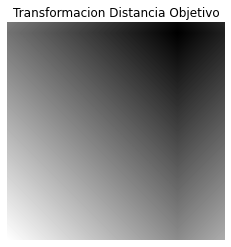

In [6]:
dts = example.Distance_Transform()
dtg = example.Distance_Transform(solids=False)
example.Plot(dts, 'Transformacion Distancia Obstaculos')
example.Plot(dtg, 'Transformacion Distancia Objetivo')

In [7]:
#image = TestCases.mainproblem()
#AStarSearch(image).Robotic_Navigation()

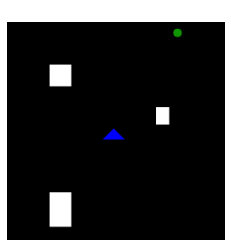

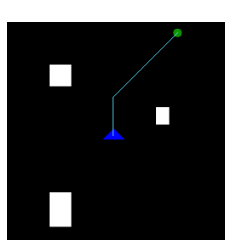

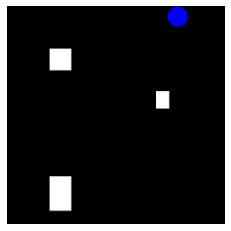

In [8]:
image = TestCases.mainproblem()
im = cv2.resize(image, (256,256))
AStarSearch(im).Robotic_Navigation()

<p style="text-align:justify">La implementación del Algoritmo A estrella fue basada en el psedocódigo proporcionado por wikipedia en el siguiente enlace: <a href="https://en.wikipedia.org/wiki/A*_search_algorithm">Enlace Wikipedia</a> </p>

# Pruebas Adicionales
<br>
<p style="text-align:justify">Las siguientes son pruebas con otro tipo de problemas de navegación para comprobar la correcta aplicación del Algoritmo de búsqueda A estrella.</p>

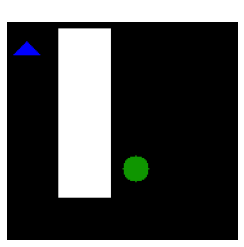

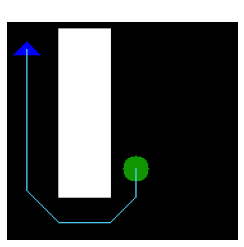

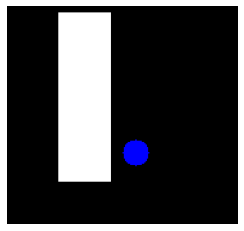

In [9]:
image = TestCases.Prueba1()
AStarSearch(image).Robotic_Navigation()

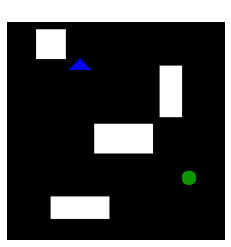

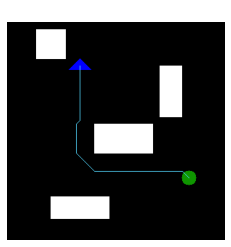

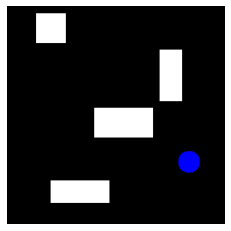

In [10]:
image = TestCases.Prueba2()
AStarSearch(image).Robotic_Navigation()

# Conclusión

<p style='text-align:justify;'> La investigación y realización del Algoritmo de Búsqueda A* fue muy interesante ya que es un algoritmo fundamental en la búsqueda de grafos, A* es un algoritmo muy utilizado en videojuegos, la mayoría de ejemplos encontrados en internet lo relacionaban al desarrollo de juegos, en lo que respecta <i>A star</i> no es un algoritmo complejo de implementar en el lenguaje de programación <i>Python</i> pero si se debe tener una idea clara de su funcionamiento, ya que se debe armar una estructura correcta sobre la primera iteración para no repetir lineas de código como en ciertos Pseudocódigos, lo que cabe destacar es que la mayoría de las implementaciones solo aplicaban sobre píxeles y no sobre polígonos que abarcan una mayor área, por lo que hacer una búsqueda de caminos solo con los píxeles podría hacer colisionar a nuestro Robot, por este motivo la aplicación de la <i>Transformación Distancia</i> a los obstáculos y al objetivo es importante ya que nos permiten tanto anticipar la distancia hacia los obstáculos, como brindarnos la distancia heurística hacia el objetivo.</p><br>
<p style='text-align:justify;'> Lo más interesante de la implementación de este proyecto fue la revisión constante de documentación de varias librerías de <i>Python</i> para ayudarnos al manejo correcto de la información, pero como tal para realizar las operaciones que se necesitaban resultaban ser más complejas, tal el caso de <i>Numpy</i>, que no puede realizar comparaciones de <i>Tuplas</i>, los mismos métodos de ordenamiento y búsqueda de la misma librería se realizaban de mejor manera sin alterar tanto los datos con arreglos estructurados, los cuales parecen ser un buen concepto de manejo de datos pero se encuentra muy limitado en cuanto a sus métodos se refiere, por lo cual fue mejor realizar una implementación alternando entre <i>Listas</i> y arreglos de <i>Numpy</i> puede tomar un mayor tiempo de complejidad, por lo que es mejor usar una clase como una estructura de tipo nodo. El Proyecto resulto ser muy interesante ya que involucra elementos de la vida real, y se le dará un seguimiento en materias posteriores de la carrera como <i>Introducción a la Inteligencia Artificial</i>, por lo que este algoritmo es de vital importancia como introducción a estos temas.</p>